# MSCS_634_Lab_6
**Name:** Komalben Suthar
**Course:** MSCS 634 – Advanced Programming Languages  
**Lab:** Assignment 6 – Association Rule Mining using Apriori and FP-Growth  
**Dataset:** Online Retail (UCI)



In [33]:
import warnings

# This line will suppress all DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

print("DeprecationWarnings have been suppressed.")

DeprecationWarnings have been suppressed.


In [34]:
# ============================
# SECTION 0: Install libraries
# ============================
# Uncomment if running in Colab
!pip install -q pandas mlxtend matplotlib seaborn openpyxl

# ============================
# SECTION 1: Imports & settings
# ============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from google.colab import files     # remove this line if not using Colab

pd.set_option('display.max_columns', 200)
sns.set(style="whitegrid")


In [35]:
# ============================
# SECTION 2: Upload / Load data
# ============================
# Using a static file path as requested.
file_path = "/content/drive/MyDrive/Komal/Lab 6/Online Retail.xlsx"

print("Loading file from:", file_path)

# Many versions of the dataset have a single sheet. If your file has a different sheet name, adjust.
df = pd.read_excel(file_path, sheet_name=0)
print("Initial rows and columns:", df.shape)
display(df.head())

Loading file from: /content/drive/MyDrive/Komal/Lab 6/Online Retail.xlsx
Initial rows and columns: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [36]:
# ============================
# SECTION 3: Data cleaning & basic exploration
# ============================
# Show initial info
print("Columns:", df.columns.tolist())
print("\nMissing values per column:")
print(df.isnull().sum())

# Basic cleaning steps recommended for this dataset
df_clean = df.copy()

# Drop cancelled orders: Invoices that start with 'C' are returns / cancellations
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]

# Remove rows without CustomerID or Description
df_clean = df_clean.dropna(subset=['CustomerID', 'Description'])

# Keep only positive quantities and positive prices
df_clean = df_clean[(df_clean['Quantity'] > 0)]
if 'UnitPrice' in df_clean.columns:
    df_clean = df_clean[df_clean['UnitPrice'] > 0]

# Convert InvoiceNo to string (transaction id)
df_clean['InvoiceNo'] = df_clean['InvoiceNo'].astype(str)

print("After cleaning rows and columns:", df_clean.shape)
display(df_clean.head())


Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

Missing values per column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
After cleaning rows and columns: (397884, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Unique invoices: 18532
Unique items (descriptions): 3877


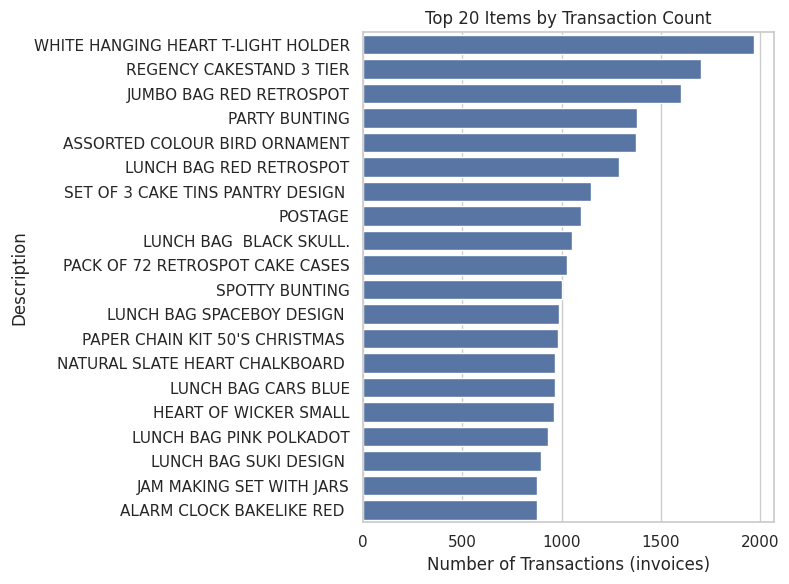

In [37]:
# Quick stats and a couple visual checks
print("Unique invoices:", df_clean['InvoiceNo'].nunique())
print("Unique items (descriptions):", df_clean['Description'].nunique())

# top 20 items by transactions count
top_items = (df_clean.groupby('Description')['InvoiceNo']
             .nunique().sort_values(ascending=False).head(20))
plt.figure(figsize=(8,6))
sns.barplot(x=top_items.values, y=top_items.index)
plt.title('Top 20 Items by Transaction Count')
plt.xlabel('Number of Transactions (invoices)')
plt.tight_layout()
plt.show()


In [38]:
# ============================
# SECTION 4: Build transaction matrix (one-hot)
# ============================
# Create basket: rows = InvoiceNo, columns = Description, values = sum(Quantity)
basket = (df_clean
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack(fill_value=0))

# Convert to 1/0
basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)

print("Transaction matrix shape:", basket_sets.shape)
display(basket_sets.iloc[:5, :10])  # show first 5 transactions and first 10 items


/tmp/ipython-input-2916044300.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)


Transaction matrix shape: (18532, 3877)


Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET
InvoiceNo,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0


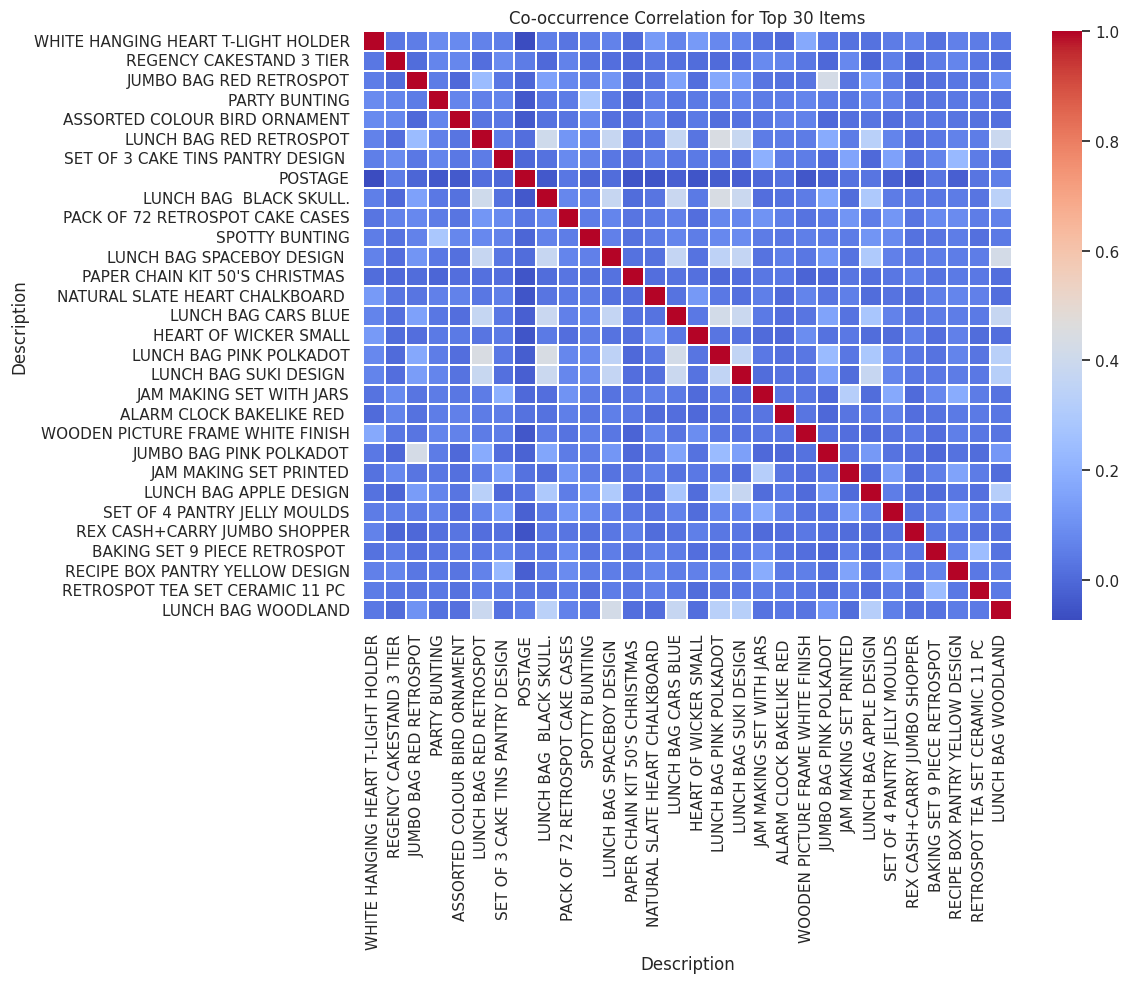

In [39]:
# ============================
# SECTION 5: Item co-occurrence heatmap (optional small subset)
# ============================
# Correlation for top N items to keep heatmap readable
top_n = 30
most_common = basket_sets.sum().sort_values(ascending=False).head(top_n).index
corr_subset = basket_sets[most_common].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_subset, cmap='coolwarm', linewidths=0.2)
plt.title(f'Co-occurrence Correlation for Top {top_n} Items')
plt.tight_layout()
plt.show()


In [40]:
# ============================
# SECTION 6: Apriori - find frequent itemsets
# ============================
# Choose a minimum support. Start with e.g., 0.02 (2%) then adjust based on number of transactions.
min_support = 0.02
print("Running Apriori with min_support =", min_support)

start = time.time()
frequent_ap = apriori(basket_sets, min_support=min_support, use_colnames=True)
end = time.time()
time_apriori = end - start
print(f"Apriori found {len(frequent_ap)} frequent itemsets in {time_apriori:.2f} seconds")

# Sort and display top itemsets by support
frequent_ap = frequent_ap.sort_values(by='support', ascending=False).reset_index(drop=True)
display(frequent_ap.head(20))


Running Apriori with min_support = 0.02
Apriori found 243 frequent itemsets in 11.72 seconds


,support,itemsets
0,0.106357,(WHITE HANGING HEART T-LIGHT HOLDER)
1,0.091895,(REGENCY CAKESTAND 3 TIER)
2,0.086337,(JUMBO BAG RED RETROSPOT)
3,0.074412,(PARTY BUNTING)
4,0.074196,(ASSORTED COLOUR BIRD ORNAMENT)
5,0.069501,(LUNCH BAG RED RETROSPOT)
6,0.061839,(SET OF 3 CAKE TINS PANTRY DESIGN )
7,0.059303,(POSTAGE)
8,0.056767,(LUNCH BAG BLACK SKULL.)
9,0.055526,(PACK OF 72 RETROSPOT CAKE CASES)


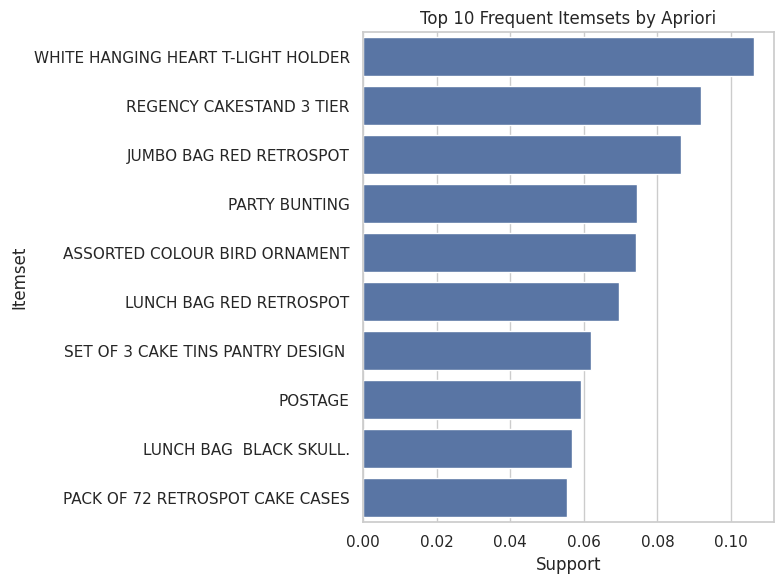

In [41]:
# Visualize top N frequent itemsets (convert itemsets to string)
top_n = 10
top_ap = frequent_ap.head(top_n).copy()
top_ap['itemset_str'] = top_ap['itemsets'].apply(lambda x: ', '.join(list(x)))
plt.figure(figsize=(8,6))
sns.barplot(x='support', y='itemset_str', data=top_ap)
plt.xlabel('Support')
plt.ylabel('Itemset')
plt.title(f'Top {top_n} Frequent Itemsets by Apriori')
plt.tight_layout()
plt.show()


Please note that suppressing warnings should be done cautiously. While it can clean up your output, it also means you might miss important information about features that will be removed in future versions of libraries you are using. In this specific case, since it's a system-level warning, suppressing it for the notebook session is generally acceptable if it's not hindering your development.

In [42]:
# ============================
# SECTION 7: FP-Growth - find frequent itemsets
# ============================
print("Running FP-Growth with same min_support =", min_support)

start = time.time()
frequent_fp = fpgrowth(basket_sets, min_support=min_support, use_colnames=True)
end = time.time()
time_fpgrowth = end - start
print(f"FP-Growth found {len(frequent_fp)} frequent itemsets in {time_fpgrowth:.2f} seconds")

frequent_fp = frequent_fp.sort_values(by='support', ascending=False).reset_index(drop=True)
display(frequent_fp.head(20))


Running FP-Growth with same min_support = 0.02
FP-Growth found 243 frequent itemsets in 8.64 seconds


,support,itemsets
0,0.106357,(WHITE HANGING HEART T-LIGHT HOLDER)
1,0.091895,(REGENCY CAKESTAND 3 TIER)
2,0.086337,(JUMBO BAG RED RETROSPOT)
3,0.074412,(PARTY BUNTING)
4,0.074196,(ASSORTED COLOUR BIRD ORNAMENT)
5,0.069501,(LUNCH BAG RED RETROSPOT)
6,0.061839,(SET OF 3 CAKE TINS PANTRY DESIGN )
7,0.059303,(POSTAGE)
8,0.056767,(LUNCH BAG BLACK SKULL.)
9,0.055526,(PACK OF 72 RETROSPOT CAKE CASES)


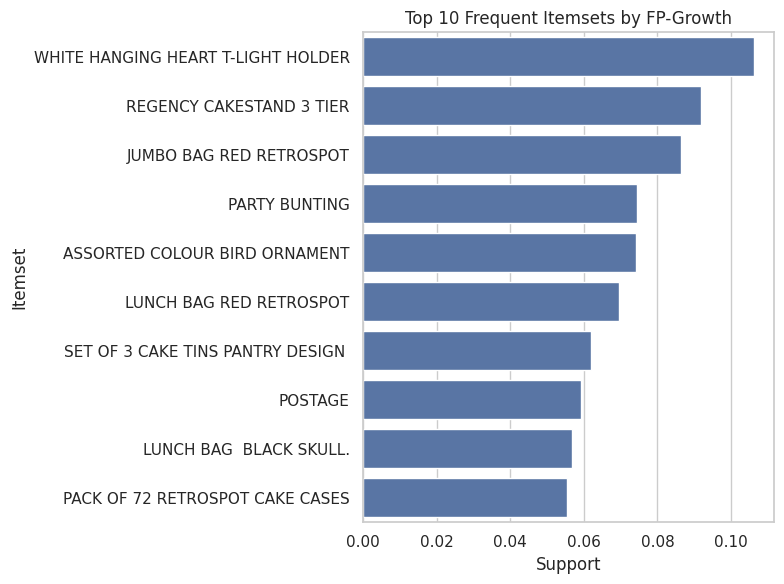

In [43]:
# Visualize FP-Growth top itemsets
top_fp = frequent_fp.head(top_n).copy()
top_fp['itemset_str'] = top_fp['itemsets'].apply(lambda x: ', '.join(list(x)))
plt.figure(figsize=(8,6))
sns.barplot(x='support', y='itemset_str', data=top_fp)
plt.xlabel('Support')
plt.ylabel('Itemset')
plt.title(f'Top {top_n} Frequent Itemsets by FP-Growth')
plt.tight_layout()
plt.show()


In [44]:
# ============================
# SECTION 8: Compare Apriori vs FP-Growth
# ============================
print("Number of frequent itemsets: Apriori =", len(frequent_ap), ", FP-Growth =", len(frequent_fp))
print(f"Timing: Apriori = {time_apriori:.2f} sec, FP-Growth = {time_fpgrowth:.2f} sec")

# Optional: show itemsets that appear in Apriori but not in FP, and vice versa
set_ap = set(frozenset(x) for x in frequent_ap['itemsets'])
set_fp = set(frozenset(x) for x in frequent_fp['itemsets'])

only_ap = set_ap - set_fp
only_fp = set_fp - set_ap
print("Itemsets only in Apriori:", len(only_ap))
print("Itemsets only in FP-Growth:", len(only_fp))


Number of frequent itemsets: Apriori = 243 , FP-Growth = 243
Timing: Apriori = 11.72 sec, FP-Growth = 8.64 sec
Itemsets only in Apriori: 0
Itemsets only in FP-Growth: 0


In [45]:
# ============================
# SECTION 9: Generate association rules
# ============================
min_confidence = 0.3
print("Generating rules from Apriori itemsets with min_confidence =", min_confidence)
rules_ap = association_rules(frequent_ap, metric="confidence", min_threshold=min_confidence)
rules_ap = rules_ap.sort_values(['confidence','lift'], ascending=[False,False]).reset_index(drop=True)
print("Apriori rules count:", len(rules_ap))
display(rules_ap.head(20))

print("\nGenerating rules from FP-Growth itemsets with same min_confidence")
rules_fp = association_rules(frequent_fp, metric="confidence", min_threshold=min_confidence)
rules_fp = rules_fp.sort_values(['confidence','lift'], ascending=[False,False]).reset_index(drop=True)
print("FP-Growth rules count:", len(rules_fp))
display(rules_fp.head(20))


Generating rules from Apriori itemsets with min_confidence = 0.3
Apriori rules count: 68


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.023527,0.037287,0.021045,0.894495,23.989564,1.0,0.020167,9.124846,0.981405,0.529172,0.890409,0.729447
1,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.024822,0.042251,0.021045,0.847826,20.066300,1.0,0.019996,6.293778,0.974350,0.457210,0.841113,0.672955
2,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.030002,0.037287,0.024822,0.827338,22.188466,1.0,0.023703,5.575714,0.984468,0.584498,0.820651,0.746520
3,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.030002,0.042251,0.023527,0.784173,18.559754,1.0,0.022259,4.437569,0.975384,0.482835,0.774651,0.670503
4,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.037287,0.042251,0.029193,0.782923,18.530185,1.0,0.027617,4.412029,0.982675,0.579850,0.773347,0.736928
5,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.034265,0.040794,0.024984,0.729134,17.873424,1.0,0.023586,3.541254,0.977547,0.498922,0.717614,0.670784
6,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.029193,0.030002,0.021045,0.720887,24.027846,1.0,0.020169,3.475290,0.987201,0.551627,0.712254,0.711163
7,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.030002,0.029193,0.021045,0.701439,24.027846,1.0,0.020169,3.251619,0.988024,0.551627,0.692461,0.711163
8,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.042251,0.037287,0.029193,0.690932,18.530185,1.0,0.027617,3.114894,0.987768,0.579850,0.678962,0.736928
9,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX ),0.033240,0.037988,0.022879,0.688312,18.119023,1.0,0.021617,3.086454,0.977294,0.473214,0.676004,0.645292



Generating rules from FP-Growth itemsets with same min_confidence
FP-Growth rules count: 68


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.023527,0.037287,0.021045,0.894495,23.989564,1.0,0.020167,9.124846,0.981405,0.529172,0.890409,0.729447
1,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.024822,0.042251,0.021045,0.847826,20.066300,1.0,0.019996,6.293778,0.974350,0.457210,0.841113,0.672955
2,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.030002,0.037287,0.024822,0.827338,22.188466,1.0,0.023703,5.575714,0.984468,0.584498,0.820651,0.746520
3,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.030002,0.042251,0.023527,0.784173,18.559754,1.0,0.022259,4.437569,0.975384,0.482835,0.774651,0.670503
4,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.037287,0.042251,0.029193,0.782923,18.530185,1.0,0.027617,4.412029,0.982675,0.579850,0.773347,0.736928
5,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.034265,0.040794,0.024984,0.729134,17.873424,1.0,0.023586,3.541254,0.977547,0.498922,0.717614,0.670784
6,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.029193,0.030002,0.021045,0.720887,24.027846,1.0,0.020169,3.475290,0.987201,0.551627,0.712254,0.711163
7,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.030002,0.029193,0.021045,0.701439,24.027846,1.0,0.020169,3.251619,0.988024,0.551627,0.692461,0.711163
8,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.042251,0.037287,0.029193,0.690932,18.530185,1.0,0.027617,3.114894,0.987768,0.579850,0.678962,0.736928
9,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX ),0.033240,0.037988,0.022879,0.688312,18.119023,1.0,0.021617,3.086454,0.977294,0.473214,0.676004,0.645292


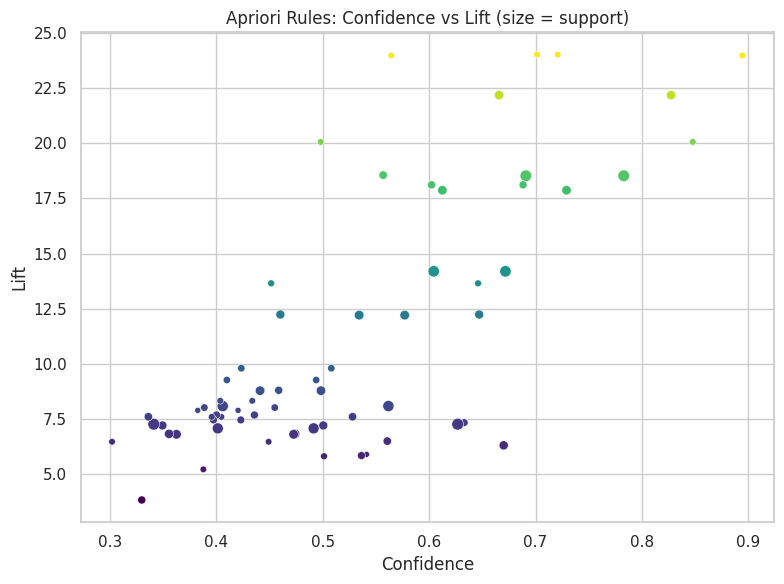

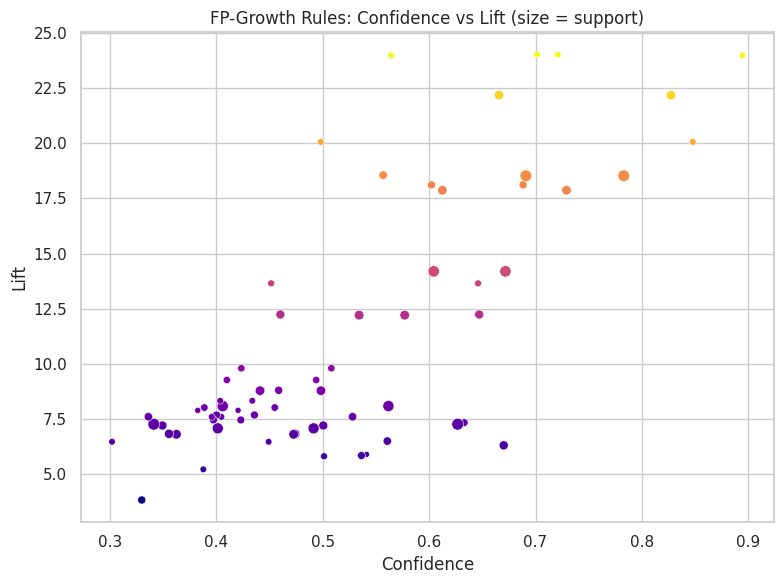

In [46]:
# Visualize rules: confidence vs lift, sized by support (Apriori)
plt.figure(figsize=(8,6))
sns.scatterplot(data=rules_ap, x='confidence', y='lift', size='support', hue='lift', palette='viridis', legend=False)
plt.title('Apriori Rules: Confidence vs Lift (size = support)')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.tight_layout()
plt.show()

# Visualize rules: confidence vs lift, sized by support (FP-Growth)
plt.figure(figsize=(8,6))
sns.scatterplot(data=rules_fp, x='confidence', y='lift', size='support', hue='lift', palette='plasma', legend=False)
plt.title('FP-Growth Rules: Confidence vs Lift (size = support)')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.tight_layout()
plt.show()


In [49]:
# ============================
# SECTION 10: Interpret top rules and save outputs
# ============================
# Show top rules by lift and support
print("Top 10 Apriori rules by lift")
display(rules_ap.sort_values('lift', ascending=False).head(10))

print("Top 10 FP-Growth rules by lift")
display(rules_fp.sort_values('lift', ascending=False).head(10))

# Save outputs for submission
frequent_ap.to_csv('frequent_itemsets_apriori.csv', index=False)
frequent_fp.to_csv('frequent_itemsets_fpgrowth.csv', index=False)
rules_ap.to_csv('association_rules_apriori.csv', index=False)
rules_fp.to_csv('association_rules_fpgrowth.csv', index=False)

# If in Colab, download zip or individual files
files.download('frequent_itemsets_apriori.csv')
files.download('frequent_itemsets_fpgrowth.csv')
files.download('association_rules_apriori.csv')
files.download('association_rules_fpgrowth.csv')


Top 10 Apriori rules by lift


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
7,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.030002,0.029193,0.021045,0.701439,24.027846,1.0,0.020169,3.251619,0.988024,0.551627,0.692461,0.711163
6,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.029193,0.030002,0.021045,0.720887,24.027846,1.0,0.020169,3.475290,0.987201,0.551627,0.712254,0.711163
0,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.023527,0.037287,0.021045,0.894495,23.989564,1.0,0.020167,9.124846,0.981405,0.529172,0.890409,0.729447
21,(GREEN REGENCY TEACUP AND SAUCER),"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",0.037287,0.023527,0.021045,0.564399,23.989564,1.0,0.020167,2.241671,0.995432,0.529172,0.553904,0.729447
2,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.030002,0.037287,0.024822,0.827338,22.188466,1.0,0.023703,5.575714,0.984468,0.584498,0.820651,0.746520
12,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.037287,0.030002,0.024822,0.665702,22.188466,1.0,0.023703,2.901595,0.991917,0.584498,0.655362,0.746520
33,(ROSES REGENCY TEACUP AND SAUCER ),"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",0.042251,0.024822,0.021045,0.498084,20.066300,1.0,0.019996,1.942912,0.992082,0.457210,0.485309,0.672955
1,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.024822,0.042251,0.021045,0.847826,20.066300,1.0,0.019996,6.293778,0.974350,0.457210,0.841113,0.672955
3,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.030002,0.042251,0.023527,0.784173,18.559754,1.0,0.022259,4.437569,0.975384,0.482835,0.774651,0.670503
24,(ROSES REGENCY TEACUP AND SAUCER ),(PINK REGENCY TEACUP AND SAUCER),0.042251,0.030002,0.023527,0.556833,18.559754,1.0,0.022259,2.188785,0.987858,0.482835,0.543125,0.670503


Top 10 FP-Growth rules by lift


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
7,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.030002,0.029193,0.021045,0.701439,24.027846,1.0,0.020169,3.251619,0.988024,0.551627,0.692461,0.711163
6,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.029193,0.030002,0.021045,0.720887,24.027846,1.0,0.020169,3.475290,0.987201,0.551627,0.712254,0.711163
0,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.023527,0.037287,0.021045,0.894495,23.989564,1.0,0.020167,9.124846,0.981405,0.529172,0.890409,0.729447
21,(GREEN REGENCY TEACUP AND SAUCER),"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",0.037287,0.023527,0.021045,0.564399,23.989564,1.0,0.020167,2.241671,0.995432,0.529172,0.553904,0.729447
2,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.030002,0.037287,0.024822,0.827338,22.188466,1.0,0.023703,5.575714,0.984468,0.584498,0.820651,0.746520
12,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.037287,0.030002,0.024822,0.665702,22.188466,1.0,0.023703,2.901595,0.991917,0.584498,0.655362,0.746520
33,(ROSES REGENCY TEACUP AND SAUCER ),"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",0.042251,0.024822,0.021045,0.498084,20.066300,1.0,0.019996,1.942912,0.992082,0.457210,0.485309,0.672955
1,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.024822,0.042251,0.021045,0.847826,20.066300,1.0,0.019996,6.293778,0.974350,0.457210,0.841113,0.672955
3,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.030002,0.042251,0.023527,0.784173,18.559754,1.0,0.022259,4.437569,0.975384,0.482835,0.774651,0.670503
24,(ROSES REGENCY TEACUP AND SAUCER ),(PINK REGENCY TEACUP AND SAUCER),0.042251,0.030002,0.023527,0.556833,18.559754,1.0,0.022259,2.188785,0.987858,0.482835,0.543125,0.670503


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>